In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision import transforms
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

class NumberPlateDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        # Only include images with .png extension (your dataset uses .png)
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        # Corresponding XML
        xml_filename = os.path.splitext(img_filename)[0] + ".xml"
        ann_path = os.path.join(self.ann_dir, xml_filename)

        if not os.path.exists(ann_path):
            raise FileNotFoundError(f"Annotation not found for {img_filename}")

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Parse XML
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text.lower().strip()
            if label != "licence":  # only consider licence plates
                continue

            bndbox = obj.find("bndbox")
            xmin = int(float(bndbox.find("xmin").text))
            ymin = int(float(bndbox.find("ymin").text))
            xmax = int(float(bndbox.find("xmax").text))
            ymax = int(float(bndbox.find("ymax").text))
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # only 1 class: licence

        # Skip images with no boxes
        if len(boxes) == 0:
            raise ValueError(f"No bounding boxes found for {img_filename}")

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            img = self.transform(img)

        return img, target


In [51]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))

transform = transforms.Compose([transforms.ToTensor()])

dataset = NumberPlateDataset("images", "annotations", transform=transform)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Test loading one batch
images, targets = next(iter(train_loader))
print("Images loaded:", len(images))
print("First image boxes:", targets[0]['boxes'])


Images loaded: 2
First image boxes: tensor([[295., 166., 355., 185.],
        [ 67.,  91.,  95.,  98.]])


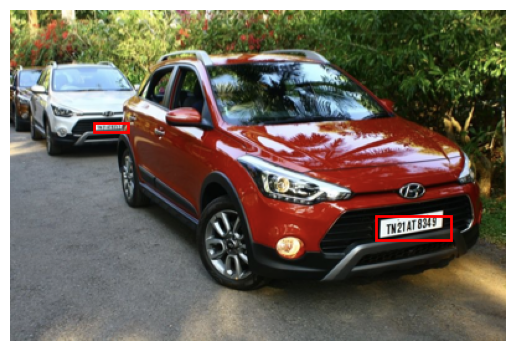

In [52]:
import matplotlib.pyplot as plt

img_tensor = images[0]
img = img_tensor.permute(1, 2, 0).numpy()  # [H,W,C]

boxes = targets[0]['boxes'].numpy()

plt.imshow(img)
for box in boxes:
    x1, y1, x2, y2 = box
    plt.gca().add_patch(
        plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
    )
plt.axis('off')
plt.show()


In [54]:
import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn

model = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
num_classes = 2  # 1 class + background

in_features = model.roi_heads.box_predictor.cls_score.in_features
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [67]:
import torch
from tqdm import tqdm

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5


In [ ]:

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f}")


finished


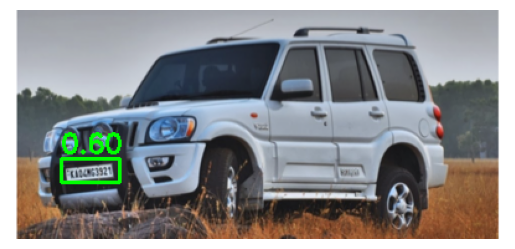

In [68]:
import cv2
import matplotlib.pyplot as plt

model.eval()

test_img_path = "images/Cars117.png"
img = Image.open(test_img_path).convert("RGB")
img_tensor = transforms.ToTensor()(img).to(device)
pred = model([img_tensor])[0]

# Draw detections
img_cv = cv2.imread(test_img_path)
for box, score in zip(pred["boxes"], pred["scores"]):
    if score > 0.5:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_cv, f"{score:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [70]:
torch.save(model, "learned_plate_detection")